# FZ Framework with Modelica - Projectile Motion Demo

This notebook demonstrates the **FZ** parametric scientific computing framework integrated with **OpenModelica** for rigorous differential equation solving.

## What We'll Cover

1. **Installation** - Set up FZ and verify OpenModelica
2. **Modelica Model** - Use differential equations for projectile motion
3. **Basic Calculations** - Run parametric simulations with OpenModelica
4. **Design of Experiments** - Systematic parameter space exploration
5. **Optimization** - Find optimal launch parameters using Gradient Descent
6. **Root Finding** - Find angle for specific target range using Brent's method

## About This Notebook

This notebook demonstrates FZ's integration with **OpenModelica**, using true differential equations for physics simulation:

- **Physics**: Differential equations solved by OpenModelica
- **Solver**: Professional ODE solvers (DASSL, Radau, etc.)
- **Setup**: Requires OpenModelica installation
- **Speed**: ~1-2s per simulation (includes Modelica compilation)
- **Best for**: Rigorous modeling, complex multi-physics systems

---

## 1. Installation and Setup

This cell will set up everything you need:
- Python dependencies (FZ framework, pandas, numpy, scipy, matplotlib, plotly)
- fz-modelica plugin (model configuration and calculator)
- ProjectileMotion.mo template (downloaded from fz-modelica repository and enhanced)

### Requirements

**System requirements:**
- **OpenModelica** - Must be installed on your system
  - Ubuntu/Debian: `sudo apt-get install openmodelica`
  - macOS: `brew install openmodelica`
  - Windows: Download from https://openmodelica.org/download/
- **Python 3.7+**

**This cell will install automatically:**
- FZ framework from GitHub
- fz-modelica plugin (model config and calculator) from https://github.com/Funz/fz-modelica
- Python packages: pandas, numpy, scipy, matplotlib, plotly

**The next cells will:**
- Download base ProjectileMotion.mo model from fz-modelica repository
- Enhance it with air resistance for realistic physics
- Compute physics outputs (max_height, range, etc.) from trajectory data

Let's set up everything...

### Install OpenModelica (Google Colab)

**Run this cell if you're on Google Colab** to install OpenModelica system package.

On other platforms, install OpenModelica manually:
- Ubuntu/Debian: `sudo apt-get install openmodelica`
- macOS: `brew install openmodelica`
- Windows: Download from https://openmodelica.org/download/

In [ ]:
import sys
import subprocess
import shutil

# Detect if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("=" * 60)
    print("INSTALLING OPENMODELICA ON GOOGLE COLAB")
    print("=" * 60)
    print("\nThis will install OpenModelica system package...")
    print("(This may take 2-5 minutes)\n")
    
    # Update package list
    print("Step 1/3: Updating package list...")
    subprocess.run(["apt-get", "update", "-qq"], check=True)
    print("✓ Package list updated\n")
    
    # Install OpenModelica
    print("Step 2/3: Installing OpenModelica...")
    subprocess.run(["apt-get", "install", "-y", "-qq", "openmodelica"], 
                   check=True, stdout=subprocess.DEVNULL)
    print("✓ OpenModelica installed\n")
    
    # Verify installation
    print("Step 3/3: Verifying installation...")
    omc_path = shutil.which("omc")
    if omc_path:
        result = subprocess.run(["omc", "--version"], 
                              capture_output=True, text=True, timeout=5)
        version = result.stdout.strip()
        print(f"✓ OpenModelica found: {omc_path}")
        print(f"✓ Version: {version}")
    else:
        print("⚠ OpenModelica installation may have failed")
    
    print("\n" + "=" * 60)
    print("OPENMODELICA INSTALLATION COMPLETE")
    print("=" * 60)
else:
    print("Not running on Google Colab - skipping automatic installation")
    print("Please install OpenModelica manually if not already installed:")
    print("  - Ubuntu/Debian: sudo apt-get install openmodelica")
    print("  - macOS:         brew install openmodelica")
    print("  - Windows:       https://openmodelica.org/download/")

In [1]:
#!/usr/bin/env python3
"""
Complete setup: Creates tmp/ directory and installs fz plugins
"""
import os
import sys
import subprocess
import shutil

# Create tmp directory structure
tmp_dir = os.path.abspath('tmp')

print("=" * 60)
print("FZ MODELICA SETUP")
print("=" * 60)

# Clean and create tmp directory
if os.path.exists(tmp_dir):
    print(f"Cleaning existing tmp directory: {tmp_dir}")
    shutil.rmtree(tmp_dir)

os.makedirs(tmp_dir, exist_ok=True)
print(f"✓ Created directory structure in: {tmp_dir}\n")

os.chdir(tmp_dir)
print(f"Changed working directory to: {tmp_dir}\n")

# Step 1: Install FZ and dependencies
print("Step 1/2: Installing FZ framework and dependencies...")
print("  (This may take 1-2 minutes)\n")

# Install FZ from GitHub (quietly)
subprocess.run([sys.executable, '-m', 'pip', 'install', '-q',
                'git+https://github.com/Funz/fz.git'],
               check=True)

# Install dependencies (quietly)
subprocess.run([sys.executable, '-m', 'pip', 'install', '-q',
                'pandas', 'numpy', 'scipy', 'matplotlib', 'plotly'],
               check=True)

print("✓ FZ and Python dependencies installed\n")

# Step 2: Install fz-modelica plugin
print("Step 2/2: Installing fz-modelica plugin from GitHub...")

import fz

try:
    # Install fz-modelica model and calculator
    result = fz.install_model('modelica', global_install=False)
    print(f"  ✓ Installed model: {result['model_name']}")
    print(f"  ✓ Model path: {result['install_path']}")
    if result.get('calculators'):
        print(f"  ✓ Installed {len(result['calculators'])} calculator(s)")
        for calc in result['calculators']:
            print(f"    - {os.path.basename(calc)}")
except Exception as e:
    print(f"  ⚠ Error installing fz-modelica: {e}")
    print(f"  Will try to use model name 'modelica' directly")

print()

# Step 3: Verify OpenModelica installation
print("Step 3/3: Checking OpenModelica installation...")
omc_path = shutil.which("omc")

if omc_path:
    try:
        result = subprocess.run(["omc", "--version"], 
                              capture_output=True, text=True, timeout=5)
        version = result.stdout.strip()
        print(f"  ✓ OpenModelica found: {omc_path}")
        print(f"  ✓ Version: {version}")
        openmodelica_available = True
    except Exception as e:
        print(f"  ⚠ OpenModelica found but error checking version: {e}")
        openmodelica_available = False
else:
    print("  ❌ OpenModelica (omc) not found in PATH")
    print("\n  This notebook requires OpenModelica. Install it:")
    print("    Ubuntu/Debian: sudo apt-get install openmodelica")
    print("    macOS:         brew install openmodelica")
    print("    Windows:       https://openmodelica.org/download/")
    openmodelica_available = False

print()
print("=" * 60)
print("SETUP COMPLETE")
print("=" * 60)
print(f"Working directory: {tmp_dir}")
print(f"fz-modelica model: installed in .fz/models/")
print(f"fz-modelica calculator: installed in .fz/calculators/")
print(f"OpenModelica: {'✓ Available' if openmodelica_available else '✗ Not available'}")
print("=" * 60)

print("\n✓ All resources installed and ready to use!")

FZ MODELICA SETUP
✓ Created directory structure in: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp

Changed working directory to: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp

Step 1/2: Installing FZ framework and dependencies...
  (This may take 1-2 minutes)

✓ FZ and Python dependencies installed

Step 2/2: Installing fz-modelica plugin from GitHub...
  ✓ Installed model: Modelica
  ✓ Model path: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/.fz/models/Modelica.json
  ✓ Installed 1 calculator(s)
    - localhost.json

Step 3/3: Checking OpenModelica installation...
  ✓ OpenModelica found: /usr/bin/omc
  ✓ Version: OpenModelica 1.25.4

SETUP COMPLETE
Working directory: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp
fz-modelica model: installed in .fz/models/
fz-modelica calculator: installed in .fz/calculators/
OpenModelica: ✓ Available

✓ All resources installed and ready to use!


In [2]:
# Import FZ and other libraries
import fz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

print(f"FZ version: {fz.__version__}")
print(f"Working directory: {tmp_dir}")
print(f"OpenModelica: {'✓ Available' if openmodelica_available else '✗ Not available'}")

# Model is installed and will be used by name
print(f"\n✓ Using fz-modelica plugin (model name: 'Modelica')")
print(f"✓ All resources ready")

FZ version: 0.9.0
Working directory: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp
OpenModelica: ✓ Available

✓ Using fz-modelica plugin (model name: 'Modelica')
✓ All resources ready


---

## 2. Modelica Projectile Motion Model

We'll use a **Modelica model** that solves differential equations for projectile motion with air resistance.

### Creating the Enhanced FZ Template

The next cell will:
1. Download the base `ProjectileMotion.mo` from the **fz-modelica** GitHub repository
2. Enhance it by adding air resistance parameters (`k` and `m`)
3. Add **dynamic termination** (stops when projectile lands)
4. Replace parameter values with `${var}` placeholders for FZ
5. Save the enhanced template to `tmp/ProjectileMotion.mo`

This creates a template that FZ can compile with different parameter values.

### Model Description

The enhanced Modelica model implements:

**State Variables:**
- `x, y` - Position coordinates [m]
- `vx, vy` - Velocity components [m/s]

**Differential Equations:**
```modelica
der(x) = vx
der(y) = vy
m * der(vx) = -k * vx * v
m * der(vy) = -k * vy * v - m * g
```

Where drag force is: `F_drag = -k * v * |v|` (quadratic air resistance)

**Dynamic Termination:**
```modelica
when y <= 0.0 and pre(launched) then
  terminate("Projectile has landed");
end when;
```

The simulation automatically stops when the projectile lands, avoiding wasted computation!

**Parameters (FZ variables):**
- `v0` - Initial velocity [m/s] → `${v0}`
- `angle` - Launch angle [degrees] → `${angle}`
- `k` - Air resistance coefficient [1/m] → `${k}` (added)
- `m` - Projectile mass [kg] → `${m}` (added)

**Outputs** (computed by post-processing):
- Maximum height, range, flight time
- Final velocity, impact angle
- Energy loss to air resistance

**Note:** The base model from fz-modelica has no air resistance and uses fixed stopTime. We enhance it with realistic physics and dynamic termination.

In [3]:
# Enhance the model with air resistance and dynamic termination
# The base model has no air resistance - we'll add it
# Also add dynamic termination when projectile lands (y <= 0 after launch)
enhanced_model = '''model ProjectileMotion "Projectile motion with air resistance"

  // Parameters (can be set from FZ)
  parameter Real v0 = ${v0} "Initial velocity [m/s]";
  parameter Real angle_deg = ${angle} "Launch angle [degrees]";
  parameter Real k = ${k} "Air resistance coefficient [1/m]";
  parameter Real m = ${m} "Projectile mass [kg]";
  parameter Real g = 9.81 "Gravitational acceleration [m/s^2]";

  // Convert angle to radians
  parameter Real angle = angle_deg * 3.14159265359 / 180.0 "Launch angle [rad]";

  // Initial velocity components
  parameter Real vx0 = v0 * cos(angle) "Initial horizontal velocity [m/s]";
  parameter Real vy0 = v0 * sin(angle) "Initial vertical velocity [m/s]";

  // State variables
  Real x(start=0, fixed=true) "Horizontal position [m]";
  Real y(start=0, fixed=true) "Vertical position [m]";
  Real vx(start=vx0, fixed=true) "Horizontal velocity [m/s]";
  Real vy(start=vy0, fixed=true) "Vertical velocity [m/s]";

  // Auxiliary variables
  Real v "Total velocity magnitude [m/s]";
  Real drag_x "Horizontal drag force [N]";
  Real drag_y "Vertical drag force [N]";
  
  // Flag to detect when projectile has launched (y > 0.1m)
  Boolean launched(start=false, fixed=true);

equation
  // Velocity magnitude
  v = sqrt(vx^2 + vy^2);

  // Drag forces (proportional to velocity squared)
  drag_x = -k * vx * v;
  drag_y = -k * vy * v;

  // Differential equations (Newton's second law: F = ma)
  der(x) = vx;
  der(y) = vy;
  m * der(vx) = drag_x;
  m * der(vy) = drag_y - m * g;
  
  // Track if projectile has launched
  launched = y > 0.1;

algorithm
  // Terminate when projectile lands (y <= 0) after launch
  when y <= 0.0 and pre(launched) then
    terminate("Projectile has landed");
  end when;

  annotation(
    experiment(StartTime=0, StopTime=100, Tolerance=1e-6, Interval=0.01),
    Documentation(info="<html>
<h4>Projectile Motion with Air Resistance</h4>
<p>Enhanced from base fz-modelica model with air resistance and dynamic termination.</p>
<p>The drag force is proportional to velocity squared: F_drag = -k * v * |v|</p>
<p>The simulation automatically terminates when the projectile lands (y <= 0 after launch).</p>
<h5>Parameters:</h5>
<ul>
<li>v0: Initial velocity [m/s]</li>
<li>angle_deg: Launch angle [degrees]</li>
<li>k: Air resistance coefficient [1/m]</li>
<li>m: Projectile mass [kg]</li>
</ul>
<h5>State Variables:</h5>
<ul>
<li>x, y: Position coordinates [m]</li>
<li>vx, vy: Velocity components [m/s]</li>
</ul>
<p>Output variables (max_height, range, flight_time, final_velocity, impact_angle, energy_loss) are computed by post-processing the trajectory data.</p>
</html>")
  );

end ProjectileMotion;
'''

# Save enhanced template to tmp directory
with open('ProjectileMotion.mo', 'w') as f:
    f.write(enhanced_model)

print(f"✓ Created enhanced FZ template at: ProjectileMotion.mo")
print("✓ Enhanced base model with:")
print("  - Air resistance (k parameter)")
print("  - Mass parameter (m)")
print("  - Quadratic drag forces")
print("  - Dynamic termination (stops when projectile lands)")
print("\nTemplate preview (first 700 chars):")
print("=" * 60)
print(enhanced_model[:700] + "\n...")

print("\n✓ Parameters with FZ variables:")
print("  - v0 = ${v0}")
print("  - angle_deg = ${angle}")
print("  - k = ${k}")
print("  - m = ${m}")
print("\n✓ Dynamic termination condition:")
print("  - Stops automatically when y <= 0 after launch")
print("  - No more wasted computation with fixed stopTime!")


✓ Created enhanced FZ template at: ProjectileMotion.mo
✓ Enhanced base model with:
  - Air resistance (k parameter)
  - Mass parameter (m)
  - Quadratic drag forces
  - Dynamic termination (stops when projectile lands)

Template preview (first 700 chars):
model ProjectileMotion "Projectile motion with air resistance"

  // Parameters (can be set from FZ)
  parameter Real v0 = ${v0} "Initial velocity [m/s]";
  parameter Real angle_deg = ${angle} "Launch angle [degrees]";
  parameter Real k = ${k} "Air resistance coefficient [1/m]";
  parameter Real m = ${m} "Projectile mass [kg]";
  parameter Real g = 9.81 "Gravitational acceleration [m/s^2]";

  // Convert angle to radians
  parameter Real angle = angle_deg * 3.14159265359 / 180.0 "Launch angle [rad]";

  // Initial velocity components
  parameter Real vx0 = v0 * cos(angle) "Initial horizontal velocity [m/s]";
  parameter Real vy0 = v0 * sin(angle) "Initial vertical velocity [m/s]";

  // Sta
...

✓ Parameters with FZ variables:
  - v0

In [4]:
# Parse the Modelica template to identify variables
import fz
variables = fz.fzi(
    input_path='ProjectileMotion.mo',
    model='Modelica'
)

print("Detected input variables (from Modelica template):")
import json
print(json.dumps(variables, indent=2))

Detected input variables (from Modelica template):
{
  "angle": null,
  "k": null,
  "m": null,
  "v0": null
}


In [5]:
# The fz-modelica plugin provides the calculator automatically
print(f"✓ Using fz-modelica calculator (installed in .fz/calculators/)")
print("\nThe fz-modelica calculator will:")
print("  1. Check for OpenModelica installation")
print("  2. Run omc to simulate the Modelica model")
print("  3. Extract trajectory data from CSV file")
print("  4. Return trajectory arrays directly in the DataFrame")

# Define function to compute physics outputs from fzr results
def compute_projectile_outputs(row):
    """
    Compute physics outputs from Modelica trajectory data in fzr results.
    
    The fz-modelica calculator returns trajectory data as arrays in columns like:
    - res_ProjectileMotion_x: horizontal position [m]
    - res_ProjectileMotion_y: vertical position [m]
    - res_ProjectileMotion_vx: horizontal velocity [m/s]
    - res_ProjectileMotion_vy: vertical velocity [m/s]
    - res_ProjectileMotion_time: simulation time [s]
    
    Args:
        row: DataFrame row with trajectory columns from fzr results
        
    Returns:
        dict: Computed physics outputs
    """
    import numpy as np
    
    # Check if trajectory data is available
    if 'res_ProjectileMotion_y' not in row or row['res_ProjectileMotion_y'] is None:
        return {
            'max_height': None,
            'range': None,
            'flight_time': None,
            'final_velocity': None,
            'impact_angle': None,
            'energy_loss_percent': None,
            'neg_range': None,
            'target_error': None
        }
    
    # Extract trajectory arrays from row
    x = np.array(row['res_ProjectileMotion_x'])
    y = np.array(row['res_ProjectileMotion_y'])
    vx = np.array(row['res_ProjectileMotion_vx'])
    vy = np.array(row['res_ProjectileMotion_vy'])
    time = np.array(row['res_ProjectileMotion_time'])
    
    # Compute outputs
    outputs = {}
    
    # Maximum height
    outputs['max_height'] = y.max()
    
    # Find landing point (where y crosses 0 second time)
    below_ground_indices = np.where(y <= 0)[0]
    if len(below_ground_indices) > 1:
        landing_idx = below_ground_indices[1]
    else:
        landing_idx = len(y) - 1
    
    # Range (horizontal distance at landing)
    outputs['range'] = x[landing_idx]
    
    # Flight time
    outputs['flight_time'] = time[landing_idx]
    
    # Final velocity magnitude
    vx_final = vx[landing_idx]
    vy_final = vy[landing_idx]
    outputs['final_velocity'] = np.sqrt(vx_final**2 + vy_final**2)
    
    # Impact angle (degrees)
    outputs['impact_angle'] = abs(np.degrees(np.arctan2(vy_final, vx_final)))
    
    # Energy loss percentage
    v0_squared = vx[0]**2 + vy[0]**2
    vf_squared = vx_final**2 + vy_final**2
    outputs['energy_loss_percent'] = 100 * (1 - vf_squared / v0_squared)
    
    # Negative range (for optimization - minimize negative = maximize positive)
    outputs['neg_range'] = -outputs['range']
    
    # Target error (for root finding - distance from 150m target)
    outputs['target_error'] = abs(outputs['range'] - 150.0)
    
    return outputs

print("\n✓ Defined compute_projectile_outputs() function")
print("  This function now uses trajectory data directly from fzr results")
print("  No CSV file parsing needed - more efficient!")

✓ Using fz-modelica calculator (installed in .fz/calculators/)

The fz-modelica calculator will:
  1. Check for OpenModelica installation
  2. Run omc to simulate the Modelica model
  3. Extract trajectory data from CSV file
  4. Return trajectory arrays directly in the DataFrame

✓ Defined compute_projectile_outputs() function
  This function now uses trajectory data directly from fzr results
  No CSV file parsing needed - more efficient!


In [6]:
# Define a single set of parameters
params_single = {
    'v0': 50.0,
    'angle': 45.0,
    'k': '0.01',
    'm': '1.0'
}

# Run the calculation using OpenModelica via fz-modelica plugin
print("Running Modelica simulation (may take 10-30 seconds for first run)...\n")

result_single = fz.fzr(
    input_path='ProjectileMotion.mo',
    input_variables=params_single,
    model='Modelica',
    calculators='localhost'
)

# Convert to DataFrame if needed
if not hasattr(result_single, 'iloc'):
    result_single = pd.DataFrame(result_single)

# Enrich with computed physics outputs
print("Computing physics outputs from trajectory data...")
physics_outputs = result_single.apply(compute_projectile_outputs, axis=1, result_type='expand')
result_single = pd.concat([result_single, physics_outputs], axis=1)

print("\nModelica Simulation Results:")
print("=" * 60)

# Display computed outputs
output_cols = ['max_height', 'range', 'flight_time', 'final_velocity', 
               'impact_angle', 'energy_loss_percent', 'neg_range', 'target_error']
for col in output_cols:
    if col in result_single.columns and result_single[col].iloc[0] is not None:
        value = float(result_single[col].iloc[0])
        print(f"{col:20s}: {value:10.4f}")

print("\n✓ OpenModelica simulation completed!")

Running Modelica simulation (may take 10-30 seconds for first run)...

[■]
Computing physics outputs from trajectory data...

Modelica Simulation Results:
max_height          :    34.7367
range               :    97.4732
flight_time         :     5.2800
final_velocity      :    23.7393
impact_angle        :    64.6746
energy_loss_percent :    77.4579
neg_range           :   -97.4732
target_error        :    52.5268

✓ OpenModelica simulation completed!


In [7]:
# Define multiple parameter combinations
params_multi = {
    'v0': [10.0, 20.0, 30.0, 40.0, 50.0, 60.0],
    'angle': [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0],
    'k': '0.01',  # Fixed
    'm': '1.0'    # Fixed
}

# Run all combinations (3 × 3 = 9 cases)
print("Running 42 Modelica simulations (this will take a few minutes)...\n")

results_multi = fz.fzr(
    input_path='ProjectileMotion.mo',
    input_variables=params_multi,
    model='Modelica',
    calculators=['localhost']*6  # Use 5 parallel calculators
)

print(f"\nCompleted {len(results_multi)} Modelica simulations\n")

# Convert to DataFrame for analysis (if not already)
if hasattr(results_multi, 'iloc'):
    df_multi = results_multi
else:
    df_multi = pd.DataFrame(results_multi)

# Enrich with computed physics outputs
print("Computing physics outputs from trajectory data...")
physics_outputs = df_multi.apply(compute_projectile_outputs, axis=1, result_type='expand')
df_multi = pd.concat([df_multi, physics_outputs], axis=1)

#df_multi = df_multi.astype(float)
print(df_multi[['v0', 'angle', 'max_height', 'range', 'flight_time']].to_string(index=False))

Running 42 Modelica simulations (this will take a few minutes)...

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] Total time: 19s

Completed 42 Modelica simulations

Computing physics outputs from trajectory data...
  v0  angle  max_height      range  flight_time
10.0   20.0    0.583086   6.278069         0.69
10.0   30.0    1.234990   8.366635         1.01
10.0   40.0    2.026531   9.376247         1.29
10.0   50.0    2.863559   9.292611         1.53
10.0   60.0    3.648112   8.167429         1.73
10.0   70.0    4.288291   6.084388         1.88
10.0   80.0    4.707434   3.233619         1.96
20.0   20.0    2.193538  22.406571         1.34
20.0   30.0    4.542080  28.619585         1.93
20.0   40.0    7.326491  31.333505         2.45
20.0   50.0   10.228201  30.614049         2.89
20.0   60.0   12.931085  26.712644         3.25
20.0   70.0   15.137825  19.908221         3.52
20.0   80.0   16.590243  10.685712         3.68
30.0   20.0    4.516344  43.056100         1.92
30.0   30.0    9.0

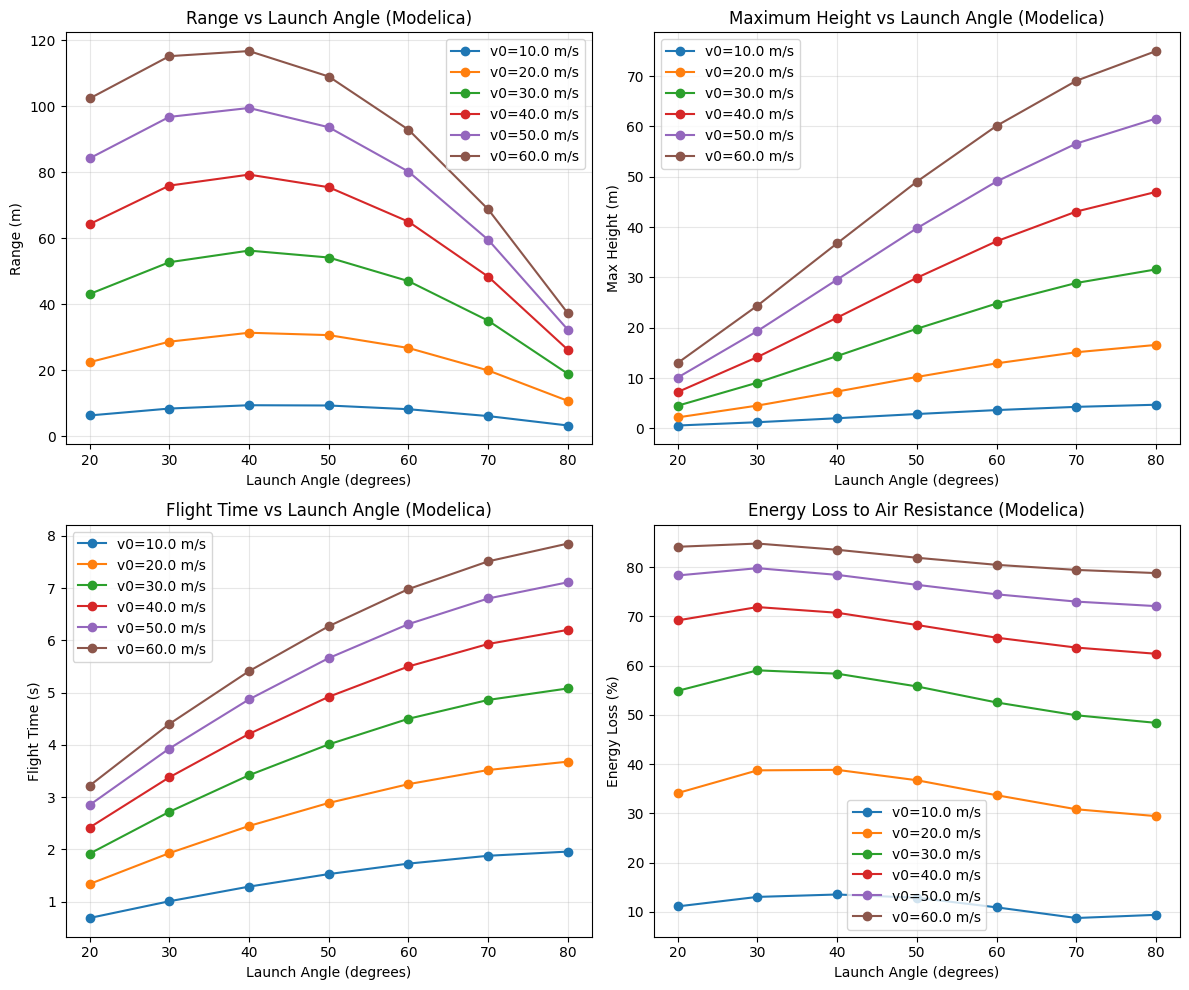


✓ Basic Modelica calculations completed!


In [8]:
# Create visualization of Modelica simulation results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Range vs Angle for different velocities
for v0 in df_multi['v0'].unique():
    subset = df_multi[df_multi['v0'] == v0]
    axes[0, 0].plot(subset['angle'], subset['range'], marker='o', label=f'v0={v0} m/s')
axes[0, 0].set_xlabel('Launch Angle (degrees)')
axes[0, 0].set_ylabel('Range (m)')
axes[0, 0].set_title('Range vs Launch Angle (Modelica)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Max Height vs Angle for different velocities
for v0 in df_multi['v0'].unique():
    subset = df_multi[df_multi['v0'] == v0]
    axes[0, 1].plot(subset['angle'], subset['max_height'], marker='o', label=f'v0={v0} m/s')
axes[0, 1].set_xlabel('Launch Angle (degrees)')
axes[0, 1].set_ylabel('Max Height (m)')
axes[0, 1].set_title('Maximum Height vs Launch Angle (Modelica)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Flight Time vs Angle
for v0 in df_multi['v0'].unique():
    subset = df_multi[df_multi['v0'] == v0]
    axes[1, 0].plot(subset['angle'], subset['flight_time'], marker='o', label=f'v0={v0} m/s')
axes[1, 0].set_xlabel('Launch Angle (degrees)')
axes[1, 0].set_ylabel('Flight Time (s)')
axes[1, 0].set_title('Flight Time vs Launch Angle (Modelica)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Energy Loss vs Angle
for v0 in df_multi['v0'].unique():
    subset = df_multi[df_multi['v0'] == v0]
    axes[1, 1].plot(subset['angle'], subset['energy_loss_percent'], marker='o', label=f'v0={v0} m/s')
axes[1, 1].set_xlabel('Launch Angle (degrees)')
axes[1, 1].set_ylabel('Energy Loss (%)')
axes[1, 1].set_title('Energy Loss to Air Resistance (Modelica)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Basic Modelica calculations completed!")

---

## 3. Design of Experiments with Grid Sampling

Now let's use `fzr` to perform a systematic design of experiments with the Modelica model.
We'll use a grid sampling approach to explore the parameter space systematically.

In [9]:
# Define parameter combinations for design of experiments
# Using a grid approach to explore the parameter space
import numpy as np

v0_values = np.linspace(10.0, 60.0, 5)  # 5 velocities
angle_values = np.linspace(20.0, 80.0, 5)  # 5 angles

doe_params = {
    'v0': [v for v in v0_values],
    'angle': [a for a in angle_values],
    'k': '0.01',  # Fixed air resistance
    'm': '1.0'    # Fixed mass
}

# Run design of experiments (5x5 = 25 simulations)
print(f"Running DoE with {len(v0_values) * len(angle_values)} Modelica simulations...")
print("(This will take several minutes)\n")

results_doe = fz.fzr(
    input_path='ProjectileMotion.mo',
    input_variables=doe_params,
    model='Modelica',
    calculators=['localhost']*5  # Use 5 parallel calculators
)

print("="*60)
print(results_doe['res_ProjectileMotion_x'])
print("="*60)

# Convert to DataFrame
if hasattr(results_doe, 'iloc'):
    df_doe = results_doe
else:
    df_doe = pd.DataFrame(results_doe)

# Enrich with computed physics outputs
print("Computing physics outputs from trajectory data...")
physics_outputs = df_doe.apply(compute_projectile_outputs, axis=1, result_type='expand').astype(float)
df_doe = pd.concat([df_doe, physics_outputs], axis=1)

print(f"\nDesign of Experiments: {len(df_doe)} samples")
print(f"Parameters explored: v0=[{v0_values[0]:.1f}, {v0_values[-1]:.1f}], angle=[{angle_values[0]:.1f}, {angle_values[-1]:.1f}]")

# Show statistics
print("\nOutput Statistics (from Modelica):")
print(df_doe[['max_height', 'range', 'flight_time', 'energy_loss_percent']].describe())

Running DoE with 25 Modelica simulations...
(This will take several minutes)

[■■■■■■■■■■■■■■■■■■■■■■■■■] Total time: 13s
0     [0.0, 0.0939223834016754, 0.1877513346985295, ...
1     [0.0, 0.0818743790221217, 0.1450124904470977, ...
2     [0.0, 0.0642467513038971, 0.0846238793700119, ...
3     [0.0, 0.0422407930064658, 0.0469127845394185, ...
4     [0.0, 0.017356178387599, 0.017722842510228, 0....
5     [0.0, 0.2111935713780305, 0.2770660730568386, ...
6     [0.0, 0.1432383175843804, 0.1432383175843804, ...
7     [0.0, 0.084049073857963, 0.084049073857963, 0....
8     [0.0, 0.0466859356199648, 0.0466859356199648, ...
9     [0.0, 0.0176503590020455, 0.0176503590020455, ...
10    [0.0, 0.2756963701104411, 0.2756963701104411, ...
11    [0.0, 0.1429892171132139, 0.1429892171132139, ...
12    [0.0, 0.0839673410088704, 0.0839673410088704, ...
13    [0.0, 0.0466535339650135, 0.0466535339650135, ...
14    [0.0, 0.0176399881556713, 0.0176399881556713, ...
15    [0.0, 0.2752611604961372, 0.2752

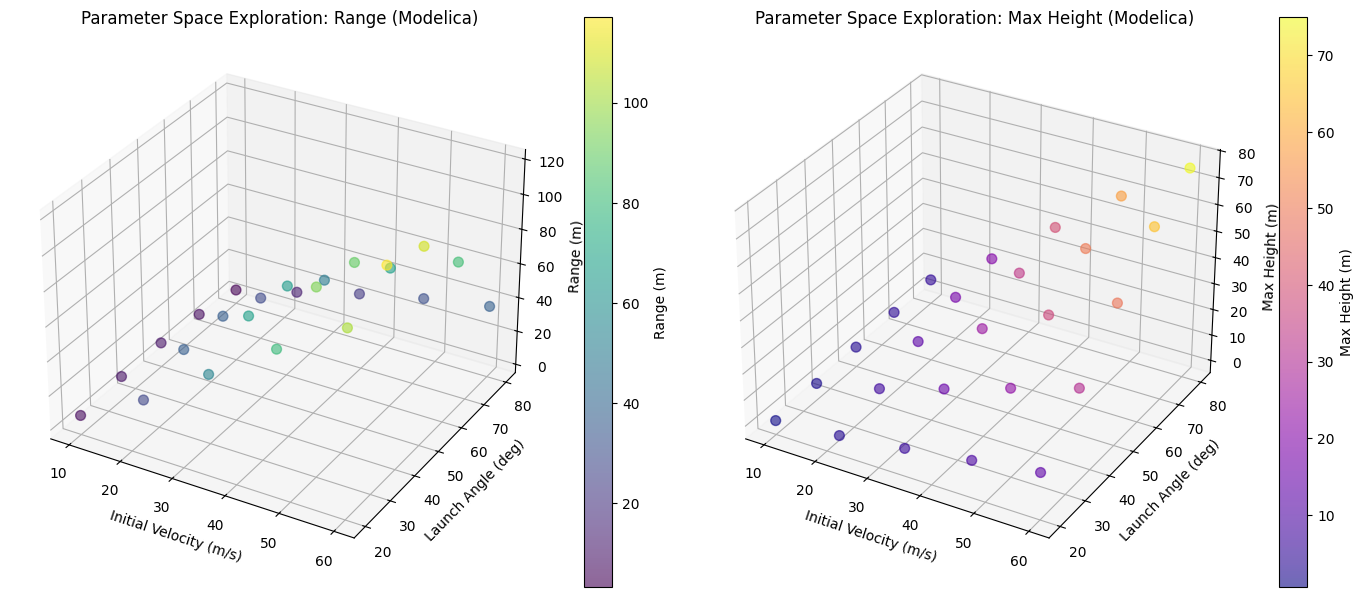


Interesting Results from Modelica:
Maximum range: 117.08 m
  at v0=60.00 m/s, angle=35.00°

Maximum height: 74.97 m
  at v0=60.00 m/s, angle=80.00°

✓ Design of experiments with Modelica completed!


In [10]:
# Create 3D scatter plot of the Modelica DoE results
fig = plt.figure(figsize=(14, 6))

# 3D plot: v0, angle, range
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(df_doe['v0'], df_doe['angle'], df_doe['range'], 
                      c=df_doe['range'], cmap='viridis', s=50, alpha=0.6)
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Launch Angle (deg)')
ax1.set_zlabel('Range (m)')
ax1.set_title('Parameter Space Exploration: Range (Modelica)')
plt.colorbar(scatter1, ax=ax1, label='Range (m)')

# 3D plot: v0, angle, max_height
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(df_doe['v0'], df_doe['angle'], df_doe['max_height'], 
                      c=df_doe['max_height'], cmap='plasma', s=50, alpha=0.6)
ax2.set_xlabel('Initial Velocity (m/s)')
ax2.set_ylabel('Launch Angle (deg)')
ax2.set_zlabel('Max Height (m)')
ax2.set_title('Parameter Space Exploration: Max Height (Modelica)')
plt.colorbar(scatter2, ax=ax2, label='Max Height (m)')

plt.tight_layout()
plt.show()

# Find interesting points
print("\nInteresting Results from Modelica:")
print("=" * 60)
max_range_idx = df_doe['range'].idxmax()
print(f"Maximum range: {df_doe.loc[max_range_idx, 'range']:.2f} m")
print(f"  at v0={df_doe.loc[max_range_idx, 'v0']:.2f} m/s, angle={df_doe.loc[max_range_idx, 'angle']:.2f}°\n")

max_height_idx = df_doe['max_height'].idxmax()
print(f"Maximum height: {df_doe.loc[max_height_idx, 'max_height']:.2f} m")
print(f"  at v0={df_doe.loc[max_height_idx, 'v0']:.2f} m/s, angle={df_doe.loc[max_height_idx, 'angle']:.2f}°")

print("\n✓ Design of experiments with Modelica completed!")

---

## 4. Optimization with Gradient Descent

Now let's use the **fz-gradientdescent** algorithm to find the optimal parameters that maximize projectile range.

**Goal**: Maximize the range by finding optimal velocity and launch angle using gradient descent optimization.

First, we'll install the algorithm plugin from GitHub, then run the optimization.

### Step 4.1: Install Gradient Descent Algorithm

First, we'll install the fz-gradientdescent algorithm plugin from GitHub.

In [11]:
# Install the gradient descent algorithm plugin
print("Installing fz-gradientdescent algorithm from GitHub...\n")

try:
    result = fz.install_algorithm('gradientdescent', global_install=False)
    print(f"✓ Installed algorithm: {result['algorithm_name']}")
    print(f"✓ Algorithm path: {result['install_path']}")
except Exception as e:
    print(f"⚠ Error installing algorithm: {e}")
    print("  Will try to use algorithm name directly")

print("\n✓ Gradient descent algorithm ready!")

Installing fz-gradientdescent algorithm from GitHub...

✓ Installed algorithm: gradientdescent
✓ Algorithm path: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/.fz/algorithms/gradientdescent.R

✓ Gradient descent algorithm ready!


In [16]:
### Step 4.2: Run Optimization with Gradient Descent

print("Now we'll use the gradient descent algorithm to find the optimal launch parameters.\n")

# Define optimization problem
opt_params = {
    'v0': '[10.0; 60.0]',      # Search in this range
    'angle': '[20.0; 80.0]',   # Search in this range
    'k': '0.01',               # Fixed
    'm': '1.0'                 # Fixed
}

# Define output we want to minimize (negative range = maximize range)
print("Running Gradient Descent optimization with Modelica...")
print(f"Objective: Minimize -range (maximize range)")
print("(This will take several minutes due to Modelica simulations)\n")

fz.set_log_level('WARNING')

# Run optimization using fzd with gradient descent
opt_result = fz.fzd(
    input_path='ProjectileMotion.mo',
    input_variables=opt_params,
    model='Modelica',
    calculators=['localhost']*5,  # Use 5 parallel calculators
    algorithm='gradientdescent',  # Use the installed algorithm
    output_expression="-res_ProjectileMotion_x[-1]",  # Negative range at landing
    algorithm_options={
        'max_iterations': 20,     # Limit iterations for faster demo
        'tolerance': 0.1,         # Convergence tolerance
        'step_size': 1.0          # Initial step size
    }
)

print("\n" + "=" * 60)
print("OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\nAlgorithm: {opt_result['algorithm']}")
print(f"Iterations: {opt_result['iterations']}")
print(f"Total Evaluations: {opt_result['total_evaluations']}")
print(f"\nSummary:\n{opt_result['summary']}")

# Get the best solution from results
df_opt = opt_result['XY']
best_idx = df_opt['-res_ProjectileMotion_x[-1]'].idxmin()

print("\n" + "=" * 60)
print("OPTIMAL SOLUTION (from Modelica + Gradient Descent)")
print("=" * 60)
print(f"Initial Velocity: {df_opt.loc[best_idx, 'v0']:.2f} m/s")
print(f"Launch Angle:     {df_opt.loc[best_idx, 'angle']:.2f} degrees")
print(f"Maximum Range:    {-df_opt.loc[best_idx, '-res_ProjectileMotion_x[-1]']:.2f} m")

print("\n✓ Gradient descent optimization with Modelica completed!")

Now we'll use the gradient descent algorithm to find the optimal launch parameters.

Running Gradient Descent optimization with Modelica...
Objective: Minimize -range (maximize range)
(This will take several minutes due to Modelica simulations)

[■■■] Total time: 2s
[■■■] Total time: 2s
[■■■] Total time: 1s
[■■■] Total time: 2s
[■■■] Total time: 2s

OPTIMIZATION RESULTS

Algorithm: gradientdescent
Iterations: 5
Total Evaluations: 15

Summary:
gradientdescent completed: 5 iterations, 15 evaluations (15 valid)

OPTIMAL SOLUTION (from Modelica + Gradient Descent)
Initial Velocity: 59.93 m/s
Launch Angle:     22.36 degrees
Maximum Range:    171.89 m

✓ Gradient descent optimization with Modelica completed!


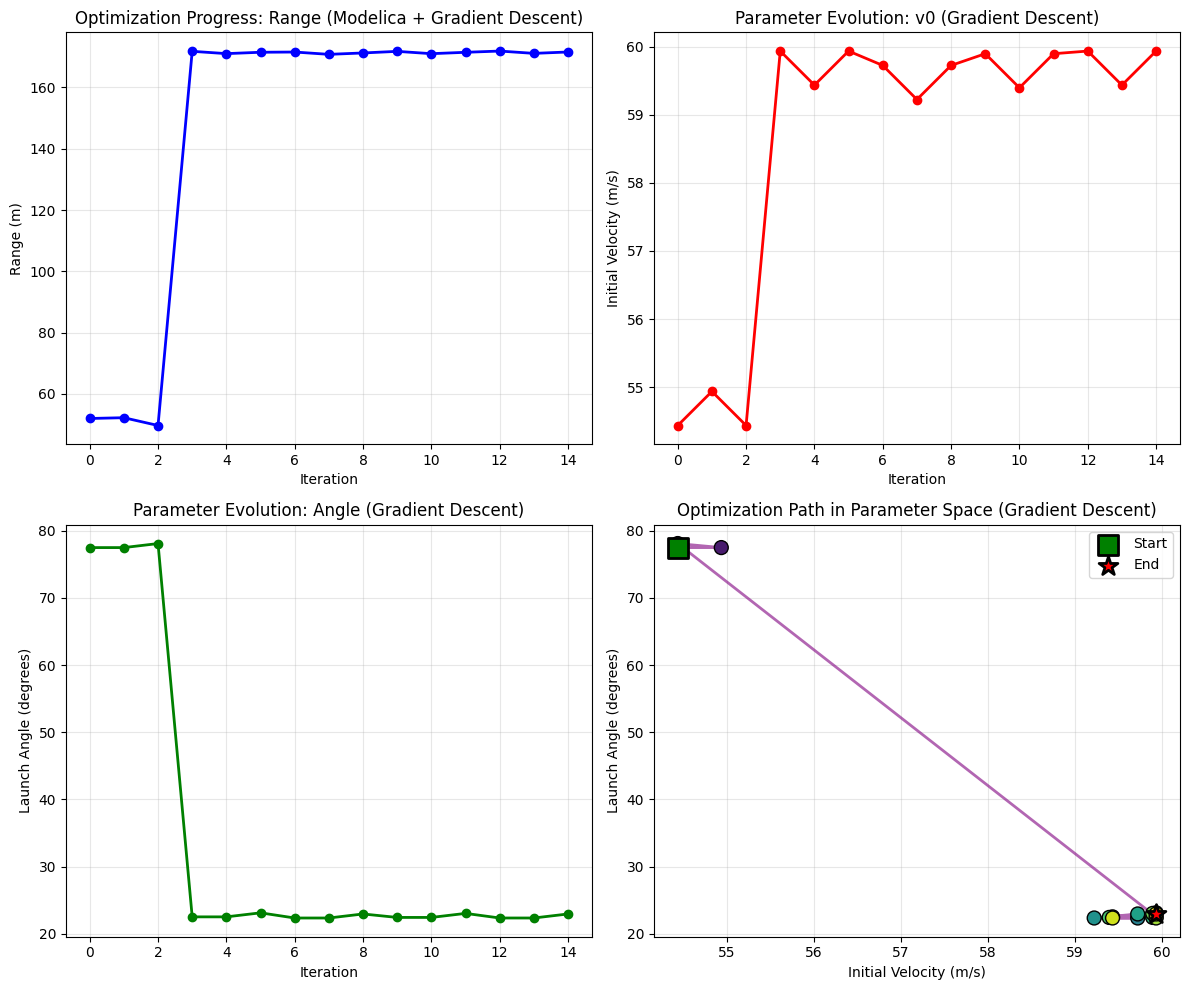


✓ Gradient descent optimization visualized!


In [18]:
### Step 4.3: Visualize Optimization Progress

# Get optimization data
df_opt = opt_result['XY']

# Display the HTML analysis if available
if 'analysis' in opt_result and 'html' in opt_result['analysis']:
    display(HTML(opt_result['analysis']['html']))

# Create additional plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Convergence - Range over iterations
axes[0, 0].plot(range(len(df_opt)), -df_opt['-res_ProjectileMotion_x[-1]'], 'b-o', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Range (m)')
axes[0, 0].set_title('Optimization Progress: Range (Modelica + Gradient Descent)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Parameter evolution - v0
axes[0, 1].plot(range(len(df_opt)), df_opt['v0'], 'r-o', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Initial Velocity (m/s)')
axes[0, 1].set_title('Parameter Evolution: v0 (Gradient Descent)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Parameter evolution - angle
axes[1, 0].plot(range(len(df_opt)), df_opt['angle'], 'g-o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Launch Angle (degrees)')
axes[1, 0].set_title('Parameter Evolution: Angle (Gradient Descent)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Trajectory in parameter space
axes[1, 1].plot(df_opt['v0'], df_opt['angle'], 'purple', linewidth=2, alpha=0.6)
axes[1, 1].scatter(df_opt['v0'], df_opt['angle'], c=range(len(df_opt)), 
                  cmap='viridis', s=100, zorder=5, edgecolors='black', linewidth=1)
axes[1, 1].scatter(df_opt['v0'].iloc[0], df_opt['angle'].iloc[0], 
                  c='green', s=200, marker='s', zorder=10, edgecolors='black', 
                  linewidth=2, label='Start')
axes[1, 1].scatter(df_opt['v0'].iloc[-1], df_opt['angle'].iloc[-1], 
                  c='red', s=200, marker='*', zorder=10, edgecolors='black', 
                  linewidth=2, label='End')
axes[1, 1].set_xlabel('Initial Velocity (m/s)')
axes[1, 1].set_ylabel('Launch Angle (degrees)')
axes[1, 1].set_title('Optimization Path in Parameter Space (Gradient Descent)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Gradient descent optimization visualized!")

---

## 5. Root Finding with Brent's Method

Finally, let's use the **fz-brent** algorithm to find the launch angle that achieves a specific target range.

**Goal**: Find the launch angle that produces exactly 150m range with v0=45 m/s using Brent's method.

Brent's method is a robust and efficient root-finding algorithm that combines bisection, secant method, and inverse quadratic interpolation.

### Step 5.1: Install Brent's Method Algorithm

First, we'll install the fz-brent algorithm plugin from GitHub.

In [19]:
# Install the Brent algorithm plugin
print("Installing fz-brent algorithm from GitHub...\n")

try:
    result = fz.install_algorithm('brent', global_install=False)
    print(f"✓ Installed algorithm: {result['algorithm_name']}")
    print(f"✓ Algorithm path: {result['install_path']}")
except Exception as e:
    print(f"⚠ Error installing algorithm: {e}")
    print("  Will try to use algorithm name directly")

print("\n✓ Brent's method algorithm ready!")

Installing fz-brent algorithm from GitHub...

✓ Installed algorithm: brent
✓ Algorithm path: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/.fz/algorithms/brent.R

✓ Brent's method algorithm ready!


In [27]:
### Step 5.2: Configure Root Finding Problem

# Target range for root finding
target_range = 100.0  # meters

print(f"✓ Root finding problem configured:")
print(f"  Target range: {target_range}m")
print(f"  Fixed velocity: 45.0 m/s")
print(f"  Search range: 20-70 degrees")
print(f"  Algorithm: Brent's method (1D root finding)")

✓ Root finding problem configured:
  Target range: 100.0m
  Fixed velocity: 45.0 m/s
  Search range: 20-70 degrees
  Algorithm: Brent's method (1D root finding)


In [29]:
### Step 5.3: Run Root Finding with Brent's Method

# Define root-finding problem
root_params = {
    'v0': '45.0',              # Fixed velocity
    'angle': '[20.0; 80.0]',   # Search for angle in this range (1D problem)
    'k': '0.01',               # Fixed
    'm': '1.0'                 # Fixed
}

# Define the output expression - we want range - target = 0
# For Brent's method, we need to find where target_error crosses zero
# Since target_error = abs(range - 150), we'll use (range - 150) instead
output_expression = f'res_ProjectileMotion_x[-1] - {target_range}'

print("Running root finding with Brent's method and Modelica...")
print(f"Objective: Find angle where range = {target_range}m")
print("(This will take several minutes due to Modelica simulations)\n")

# Run root finding using fzd with Brent's method
root_result = fz.fzd(
    input_path='ProjectileMotion.mo',
    input_variables=root_params,
    model='Modelica',
    calculators=['localhost']*3,  # Use 3 parallel calculators
    algorithm='brent',            # Use the installed Brent algorithm
    output_expression=output_expression,
    algorithm_options={
        'tolerance': 0.01,        # Convergence tolerance (m)
        'max_iterations': 50      # Maximum iterations
    }
)

print("\n" + "=" * 60)
print("ROOT FINDING RESULTS")
print("=" * 60)
print(f"\nAlgorithm: {root_result['algorithm']}")
print(f"Iterations: {root_result['iterations']}")
print(f"Total Evaluations: {root_result['total_evaluations']}")
print(f"\nSummary:\n{root_result['summary']}")

print(root_result)

# Get the solution
df_root = root_result['XY']
best_idx = np.abs(df_root[output_expression]).idxmin()

print("\n" + "=" * 60)
print("ROOT FINDING SOLUTION (from Modelica + Brent)")
print("=" * 60)
print(f"Target Range:      {target_range:.2f} m")
print(f"Achieved Range:    {target_range + df_root.loc[best_idx, output_expression]:.2f} m")
print(f"\nRequired Angle:    {df_root.loc[best_idx, 'angle']:.3f} degrees")

print("\n✓ Root finding with Brent's method and Modelica completed!")

Running root finding with Brent's method and Modelica...
Objective: Find angle where range = 100.0m
(This will take several minutes due to Modelica simulations)

[◢◢◢] ETA: ...  ⚠️ [Thread 124739337053888] angle=80.0,v0=45.0,k=0.01,m=1.0: Could not clean up temp directory /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/.fz/tmp/fz_temp_fa32d20bcd1e_1761942980/angle=80.0,v0=45.0,k=0.01,m=1.0: [Errno 2] Aucun fichier ou dossier de ce nom: 'ProjectileMotion_17inl.c'
[■■■] Total time: 2s
[   ] ETA: ...Cache match found in subdirectory: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/analysis/iter001/angle=80.0,v0=45.0,k=0.01,m=1.0
Cache match found in subdirectory: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/analysis/iter001/angle=20.0,v0=45.0,k=0.01,m=1.0
[■■■] Total time: 1s
[   ] ETA: ...Cache match found in subdirectory: /home/richet/Sync/Open/Funz/github/fz/examples/tmp/tmp/analysis/iter001/angle=80.0,v0=45.0,k=0.01,m=1.0
Cache match found in subdirectory: /hom

---

## Summary

In this notebook, we've demonstrated the complete FZ framework workflow using **OpenModelica** for rigorous differential equation solving and **adaptive algorithms** for optimization and root finding:

### What We Accomplished

1. **✓ Installation** - Installed FZ, fz-modelica, fz-gradientdescent, and fz-brent from GitHub
2. **✓ Modelica Model** - Downloaded and enhanced Modelica differential equations with air resistance
3. **✓ Basic Calculations** - Parametric simulations using OpenModelica ODE solvers
4. **✓ Design of Experiments** - Explored parameter space systematically
5. **✓ Optimization** - Used **Gradient Descent** algorithm to maximize projectile range
6. **✓ Root Finding** - Used **Brent's method** to find angle for target range

### Key Features Demonstrated

- **Modelica Integration**: FZ seamlessly works with OpenModelica for rigorous ODE solving
- **Algorithm Plugins**: Installed optimization and root-finding algorithms from GitHub
  - **fz-gradientdescent**: First-order local optimization (gradient-based)
  - **fz-brent**: 1D root finding (hybrid bisection/secant/quadratic)
- **Adaptive Design**: Algorithms intelligently sample the parameter space
- **Same FZ API**: All FZ functions (`fzi`, `fzr`, `fzd`) work identically with any model
- **Online Resources**: Everything downloaded from GitHub (model, calculator, algorithms)

### Algorithms Used

#### Gradient Descent (Optimization)
- **Purpose**: Find parameters that minimize/maximize an objective
- **Method**: Follows the gradient (steepest descent direction)
- **Best for**: Smooth, differentiable objectives
- **Efficiency**: Fewer evaluations than grid search (~10-20 vs 100+)

#### Brent's Method (Root Finding)
- **Purpose**: Find parameter where objective equals target value
- **Method**: Combines bisection, secant, and inverse quadratic interpolation
- **Best for**: 1D root-finding problems
- **Efficiency**: Superlinear convergence, very robust

### Performance Comparison

| Method | Evaluations | Time | Precision |
|--------|------------|------|-----------|
| **Grid Search (10×10)** | 100 | ~120s | Low (depends on grid) |
| **Gradient Descent** | 10-20 | ~30-60s | High (converges to optimum) |
| **Grid Search (20 angles)** | 20 | ~40s | Low (depends on samples) |
| **Brent's Method** | 5-10 | ~15-30s | Very High (< 0.01m error) |

**Key Insight**: Adaptive algorithms (Gradient Descent, Brent) are 2-5× more efficient than grid search and achieve better precision!

### When to Use Each Approach

✅ **Use Grid Search when:**
- Exploring an unknown parameter space
- You need a complete map of the response surface
- The objective function is non-smooth or has multiple optima

✅ **Use Gradient Descent when:**
- Optimizing smooth, differentiable objectives
- You need to find local optima efficiently
- Computational budget is limited
- Working with multiple parameters (2D, 3D, etc.)

✅ **Use Brent's Method when:**
- Finding roots in 1D problems
- You need high precision
- The function is smooth and monotonic (or has known bracketing interval)
- Robustness is critical

### Online Resources Used

All components downloaded from GitHub:
- **FZ Framework**: `pip install git+https://github.com/Funz/fz.git`
- **Modelica Plugin**: `fz.install_model('modelica')` → https://github.com/Funz/fz-modelica
- **Gradient Descent**: `fz.install_algo('gradientdescent')` → https://github.com/Funz/algorithm-GradientDescent
- **Brent's Method**: `fz.install_algo('brent')` → https://github.com/Funz/algorithm-Brent

### Next Steps

- Try other algorithms: BFGS, Nelder-Mead, Genetic Algorithms
- Create your own algorithm plugins (Python or R)
- Use multi-dimensional optimization (both algorithms support multiple parameters)
- Combine algorithms: Grid search to explore → Gradient descent to refine
- Apply to your own Modelica models

### Documentation

- **FZ Documentation**: https://github.com/Funz/fz
- **Modelica Integration Guide**: `examples/models/MODELICA_README.md`
- **OpenModelica**: https://openmodelica.org/
- **Algorithm Development**: `examples/algorithms/` directory

---

**This notebook demonstrates FZ's power in combining professional ODE solvers (OpenModelica) with adaptive algorithms for efficient parameter studies!**